In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import pickle
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.gaussian_process.kernels import *
import sklearn.gaussian_process.kernels
from sklearn.gaussian_process import GaussianProcessRegressor
import subprocess
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from mapie.regression import MapieQuantileRegressor, MapieRegressor  
import xgboost
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, QuantileRegressor
from xgboost import XGBRegressor

import optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
with open('MCS_RC_ex3_input_output.p','rb') as f:
    dfall = pickle.load(f)     

In [ ]:
def Ufunc(y_GP, std):
  U = np.abs(y_GP/(std+1e-6))
  idx = np.argmin(U)

  return idx, U[idx]

def Ufunc_k(y_GP, std, k = 10):
  U = np.abs(y_GP/(std+1e-6))
  idx = np.argpartition(U, k)[:k]

  return idx, U[idx]

def cal_Pf(y_GP):
  Pf = len(np.where(y_GP < 0.0)[0])/len(y_GP)
  Ri = norm.isf(Pf)
  if Pf > 0:
    CoV = ((1-Pf)/(Pf*len(y_GP)))**0.5
  else:
    CoV = 1E3

  return Pf, CoV, Ri


In [ ]:
y_MC = dfall['yout']
np.min(y_MC), np.max(y_MC)

In [ ]:
y_mc = 0.35 - y_MC

In [ ]:
Pf, CoV, Ri = cal_Pf(y_mc)
Pf, Ri, CoV

In [ ]:
list_fea = np.array(list(dfall))[:-2]
list_fea

In [ ]:
x_mc = dfall[list_fea].values
Nfea = len(list_fea)
Nfea


In [ ]:
Nsample = len(x_mc)
list_id = np.random.randint(0,Nsample,1000)
X_train_up, y_train_up  = x_mc[list_id,:Nfea], y_mc[list_id]
scaler = preprocessing.StandardScaler().fit(X_train_up[:,:Nfea])
X_scaled = scaler.transform(X_train_up[:,:Nfea])
x_mc_scaled = scaler.transform(x_mc[:,:Nfea])


### Gaussian Process

In [ ]:
list_id = np.random.randint(0,Nsample,500)
X_scaled = x_mc_scaled[list_id,:Nfea]
y_train_up = y_mc[list_id]


In [ ]:
kernel = RBF(10)
# kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5) + ConstantKernel(1) * PairwiseKernel(metric='poly', pairwise_kernels_kwargs={'degree':2})
gaussian_process = GaussianProcessRegressor(kernel = kernel);
gaussian_process.fit(X_scaled, y_train_up);
y_GPtrain, std = gaussian_process.predict(X_scaled, return_std=True)
y_GPref, std = gaussian_process.predict(x_mc_scaled, return_std=True)
list_Pf_GP = []
r2_score(y_GPref, y_mc)

In [ ]:
%%time
for i in range(30):
#   kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5) + ConstantKernel(1) * PairwiseKernel(metric='poly', pairwise_kernels_kwargs={'degree':2})
  kernel = RBF(10)
  gaussian_process = GaussianProcessRegressor(kernel = kernel);
  gaussian_process.fit(X_scaled, y_train_up);
  y_GP, std = gaussian_process.predict(x_mc_scaled[:,:Nfea], return_std=True)
  idx, U = Ufunc_k(y_GP, std, k = 50)
  Pf, CoV, Ri = cal_Pf(y_GP)
  x_new, y_new = x_mc_scaled[idx,:Nfea], y_mc[idx]
#   X_train_up = np.concatenate([X_train_up, x_new.reshape(1,-1)], axis = 0)
  X_scaled = np.concatenate([X_scaled, x_new], axis = 0)
  y_train_up = np.concatenate([y_train_up, y_new])
#   print(Pf, Ri, CoV, U, len(y_train_up))
  print(Pf, Ri, len(y_train_up))
  list_Pf_GP.append(Pf)

In [ ]:
r2_score(y_GP, y_mc)

In [ ]:
plt.scatter(y_GPref, y_mc, color = 'r');
plt.scatter(y_GP, y_mc);


### Mapie

In [ ]:
list_id = np.random.randint(0,100000,500)
X_train_up = x_mc_scaled[list_id,:Nfea]
y_train_up = y_mc[list_id]

list_id = np.random.randint(0,100000,500)
X_valid_up = x_mc_scaled[list_id,:Nfea]
y_valid_up = y_mc[list_id]


In [ ]:
def objective(trial):
    # Define hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1.0e-3, 1.0)
    max_depth= trial.suggest_int("max_depth", 2,10)
    num_leaves = trial.suggest_int('num_leaves',2, 100)
#     n_estimators=trial.suggest_int("n_estimators", 2, 1000)
    min_child_weight=trial.suggest_int("min_child_weight", 2,100)


    # Create and train the model
    model = LGBMRegressor(learning_rate=learning_rate,
                          max_depth=max_depth,
                          num_leaves = num_leaves,
#                           n_estimators=n_estimators,
                          min_child_weight=min_child_weight)
    model.fit(X_train_up, y_train_up)
    y_GP = model.predict(X_valid_up)
#     e_xgb = MSE(y_valid_up, y_GP)
    e_xgb = 1-r2_score(y_valid_up, y_GP)

    return e_xgb



In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)



In [ ]:
parameters = study.best_params
model = LGBMRegressor(learning_rate=parameters['learning_rate'],
                          max_depth=int(parameters['max_depth']),
#                           n_estimators=int(parameters['n_estimators']),
                          min_child_weight=int(parameters['min_child_weight']))

model_05 = LGBMRegressor(learning_rate=parameters['learning_rate'],
                          max_depth=int(parameters['max_depth']),
#                           n_estimators=int(parameters['n_estimators']),
                          min_child_weight=int(parameters['min_child_weight']), objective='quantile', alpha=0.05)

model_95 = LGBMRegressor(learning_rate=parameters['learning_rate'],
                          max_depth=int(parameters['max_depth']),
#                           n_estimators=int(parameters['n_estimators']),
                          min_child_weight=int(parameters['min_child_weight']), objective='quantile', alpha=0.95)

parameters


In [ ]:
k = 50
X_train_up = x_mc[:k,:Nfea]
y_train_up = y_mc[:k]

model = LGBMRegressor()
model_05 = LGBMRegressor(objective='quantile', alpha=0.05)
model_95 = LGBMRegressor(objective='quantile', alpha=0.95)

model.fit(X_train_up, y_train_up)
y_GPref = model.predict(x_mc[:,:Nfea])
list_Pf = []
r2_score(y_GPref, y_mc)
list_Ri = []

In [ ]:
%%time
for i in range(30):  
#     model.fit(X_train_up, y_train_up, init_model = model)
    model.fit(X_train_up, y_train_up)
    model_05.fit(X_train_up, y_train_up)
    model_95.fit(X_train_up, y_train_up)
   
    y_05 = model_05.predict(x_mc_scaled[:,:Nfea])
    y_95 = model_95.predict(x_mc_scaled[:,:Nfea])
    y_GP = model.predict(x_mc_scaled[:,:Nfea])
    std = np.abs(y_95-y_05)/4.0
    Pf, CoV, Ri = cal_Pf(y_GP)
    idx, U = Ufunc_k(y_GP, std,k=150)
    x_new, y_new = x_mc_scaled[idx,:Nfea], y_mc[idx]
    X_train_up = np.concatenate([X_train_up, x_new], axis = 0)
    y_train_up = np.concatenate([y_train_up, y_new])
    list_Ri.append(Ri)
    print(Pf, Ri, CoV, len(y_train_up))
    


In [ ]:
r2_score(y_GP, y_mc)    

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(y_GPref, y_mc, color = 'r');
plt.scatter(y_GP, y_mc);
plt.plot([-0.3, 0.3],[-0.3, 0.3], 'y')
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.legend(['Before', 'After', 'Ideal']);
plt.grid(True)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('aaa.png',dpi=300)

(-0.3, 0.3)

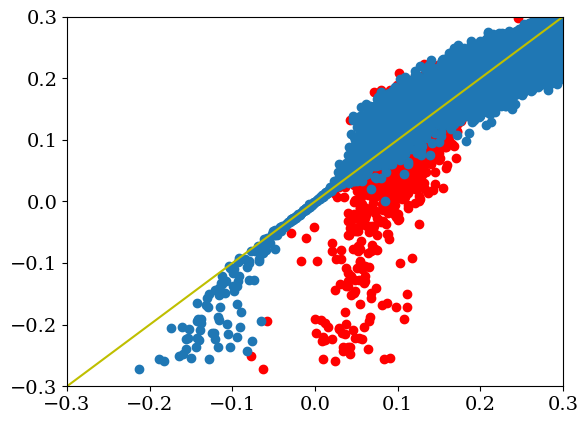

In [ ]:
list_fea

In [ ]:
df_ll = pd.DataFrame()
df_ll['LCol'] = x_mc[:,0]
df_ll['HCol'] = x_mc[:,1]
df_ll['BCol'] = x_mc[:,2]
df_ll['LBeam'] = x_mc[:,3]
df_ll['HBeam'] = x_mc[:,4]
df_ll['BBeam'] = x_mc[:,5]
df_ll['LGird'] = x_mc[:,6]
df_ll['HGird'] = x_mc[:,7]
df_ll['BGird'] = x_mc[:,8]
df_ll['cover'] = x_mc[:,9]
df_ll['AsCol'] = x_mc[:,10]
df_ll['AsBeam'] = x_mc[:,11]
df_ll['AsGird'] = x_mc[:,12]
df_ll['fc'] = x_mc[:,13]
df_ll['Ec'] = x_mc[:,14]
df_ll['Fy'] = x_mc[:,15]
df_ll['Es'] = x_mc[:,16]
df_ll['P2'] = x_mc[:,17]
df_ll['P3'] = x_mc[:,18]
df_ll['P4'] = x_mc[:,19]
df_ll['P5'] = x_mc[:,20]
df_ll['g_pred']=y_GP


In [ ]:
# df_ll = df_ll*1E4
df_ll['Ec'] = df_ll['Ec']
df_ll['Es'] = df_ll['Es']
df_ll['fc'] = -df_ll['fc']
df_ll['Fy'] = df_ll['Fy']
df_ll['P5'] = df_ll['P5']
df_ll['AsCol'] = df_ll['AsCol']
df_ll['AsBeam'] = df_ll['AsBeam']
df_ll['AsGird'] = df_ll['AsGird']
df_ll['cover'] = df_ll['cover']
df_ll['g_pred'] = df_ll['g_pred']
label = np.zeros(len(y_GP))
label[y_GP<0]=1
df_ll['out'] = label
len(y_GP[y_GP<0])


In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 14
rcParams.update({'font.size': fsize})


In [ ]:
col_name = col_name = ['L_col', 'H_col','B_col', 'L_beam', 'H_beam', 'B_beam','L_gird', 'H_gird','B_gird', 'cover','As_col','As_beam','As_gird', 'f_c', 'E_c', 'f_y', 'E_s', 'F_4', 'F_3', 'F_2', 'F_1', 'g(X)']

In [ ]:
N_rand = 20
cols = list(np.array(list(df_ll))[:-2]) + ['g_pred']
df_2 = df_ll.iloc[:len(df_ll)]
df_3 = df_ll[df_ll['out'] == 1]
df_2 = df_2.append(df_3)


fig = go.Figure(data=
    go.Parcoords(line = dict(color = df_2['out'], colorscale = [[0,'grey'],[1,'red']]),
        dimensions = [dict(label=col_name[i], values=df_2[cols[i]]) for i in range(len(cols))]))

fig.update_layout( width=1000,   height=450, font=dict(size=15),
    font_family="Times New Roman",    title_font_family="Times New Roman")

fig.update_traces( dimensions=[
        {**d, **{"tickvals": np.around(np.linspace(min(d["values"]), max(d["values"]), 3),1)  }}
        for d in fig.to_dict()["data"][0]["dimensions"]])

plt.tight_layout()
fig.show()



### Model selection

In [ ]:
from pycaret.regression import *

In [ ]:
k = 1000
X_scaled = x_mc_scaled[:k,:]
y_train_up = y_mc[:k]

In [ ]:
df = pd.DataFrame(X_scaled)
df['class'] = y_train_up
len(df)

In [ ]:
# %%time
s = setup(df, target = 'class', use_gpu=True, train_size=0.5)
best = compare_models(include=['svm', 'dt', 'rf', 'ada', 'xgboost', 'lightgbm'], cross_validation = False)

